In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pygad

import itertools
import random

from graph import Graph
from graphParser import parseGraph

In [23]:
# Load graph
from os.path import join
graph_in = "1-FullIns_3.col"
graph = parseGraph(join("graphs/", graph_in), delimiter=" ", skiprows=5)

In [24]:
#Fitness
def conflict_fitness(solution, solution_idx):
    #update graph
    graph.set_edge_colors(solution)

    # compute the number of ajacent vertices that share a color
    incorrect_verteces = 0
    for v1, v2 in graph.get_adjacent_vertices():
        if graph.get_edge_color(v1) == graph.get_edge_color(v2):
            incorrect_verteces += 1

    return 1.0 / (incorrect_verteces + 1)

def conflict_ratio_fitness(solution, solution_idx):
    graph.set_edge_colors(solution)
    return 1 - graph.num_edge_conflicts() / graph.num_edges

def optimizing_conflict_fitness(solution, solution_idx):
    graph.set_edge_colors(solution)
    num_conflicts = graph.num_edge_conflicts()
    if num_conflicts == 0:
        return 1 + (graph.num_edges - len(set(solution)))
    else:
        return 1 - num_conflicts / graph.num_edges

from math import exp
def optimizing_exp_conflict_fitness(solution, solution_idx):
    graph.set_edge_colors(solution)
    num_conflicts = graph.num_edge_conflicts()
    if num_conflicts == 0:
        return 1 + exp(graph.num_edges - len(set(solution)))
    else:
        return 1 - num_conflicts / graph.num_edges

In [25]:
def mutate_conflicted_edges(offspring, ga_instance):
    for chromosome_idx in range(offspring.shape[0]):
        # find vertices that are in conflict
        graph.set_edge_colors(offspring[chromosome_idx, :])

        conflicts = graph.get_edges_in_conflict()

        for e_idx in conflicts:
            if random.random() <= ga_instance.mutation_probability:
                offspring[chromosome_idx, e_idx] = random.choice(ga_instance.gene_space)
    
    return offspring

def mutate_anealing(offspring, ga_instance):
    global temp
    for chromoseme_idx in range(offspring.shape[0]):
        graph.set_edge_colors(offspring[chromoseme_idx, :])
        conflicts = graph.get_edges_in_conflict()

        for i, v in enumerate(offspring[chromoseme_idx, :]):
            if v in conflicts:
                if random.random() <= ga_instance.mutation_probability:
                    offspring[chromoseme_idx, i] = random.choice(ga_instance.gene_space)
            else:
                if random.random() <= ga_instance.mutation_probability / (ga_instance.generations_completed + 1):
                    offspring[chromoseme_idx, i] = random.choice(ga_instance.gene_space)
    
    return offspring

def mutate_edges(offspring, ga_instance):
    for chromoseme_idx in range(offspring.shape[0]):
        for i, v in enumerate(offspring[chromoseme_idx, :]):
            if random.random() <= ga_instance.mutation_probability:
                offspring[chromoseme_idx, i] = random.choice(ga_instance.gene_space)
    
    return offspring

In [26]:
# Crossover
def uncoflicted_crossover(parents, offspring_size, ga_instance):
    offspring = []
    idx = 0
    while len(offspring) != offspring_size[0]:
        if not (ga_instance.crossover_probability is None):
            probs = np.random.random(size=parents.shape[0])
            indices = np.where(probs <= ga_instance.crossover_probability)[0]
            # If no parent satisfied the probability, no crossover is applied and a parent is selected.
            if len(indices) == 0:
                # print(f'DEBUG: {parents[idx % parents.shape[0], :]}')
                offspring.append(parents[idx % parents.shape[0], :])
                continue
            elif len(indices) == 1:
                parent1_idx = indices[0]
                parent2_idx = parent1_idx
            else:
                indices = random.sample(set(indices), 2)
                parent1_idx = indices[0]
                parent2_idx = indices[1]
        else:
            parent1_idx = idx % parents.shape[0]
            parent2_idx = (idx + 1) % parents.shape[0]

        parent1 = parents[parent1_idx, :].copy()
        parent2 = parents[parent2_idx, :].copy()

        # random_split_point = np.random.choice(range(offspring_size[0]))
        graph.set_edge_colors(parent1)
        conflicts = graph.get_edges_in_conflict()

        parent1[conflicts] = parent2[conflicts]

        offspring.append(parent1)

        idx += 1
    
    return np.array(offspring)

In [27]:
last_fitness = 0
def callback_generation(ga_instance):
    global last_fitness
    change = ga_instance.best_solution()[1] - last_fitness
    # print("Generation = {generation}".format(generation=ga_instance.generations_completed))
    if change > 0:
        print("Generation = {generation}".format(generation=ga_instance.generations_completed))
        print("Fitness    = {fitness}".format(fitness=ga_instance.best_solution()[1]))
        print("Change     = {change}".format(change=change))
    last_fitness = ga_instance.best_solution()[1]

def callback_stop(ga_instance, fitnesses):
    global last_fitness
    last_fitness = 0

def callback_start(ga_instance):
    print("on_start()")

def callback_fitness(ga_instance, population_fitness):
    print("on_fitness()")

def callback_parents(ga_instance, selected_parents):
    print("on_parents()")

def callback_crossover(ga_instance, offspring_crossover):
    print("on_crossover()")

def callback_mutation(ga_instance, offspring_mutation):
    print("on_mutation()")


In [28]:
experiment_name = f"{graph_in}_annealing_optim_1.0.0"
num_generations = 100
ga_args = {
    "num_generations":num_generations,
    "num_parents_mating":10,
    "fitness_func":optimizing_conflict_fitness,
    "crossover_type":uncoflicted_crossover,
    "mutation_type":mutate_anealing,
    "mutation_probability":0.8,
    "crossover_probability":0.2,
    "keep_parents":True,
    "sol_per_pop":100, 
    "num_genes":graph.num_edges,
    "gene_type":int,
    "gene_space":range(0, graph.num_edges),
    "on_generation":None,
    "on_stop":callback_stop,
    "stop_criteria":["saturate_20"]
}

In [29]:
runs = 100

best_solutions = []
best_solutions_fitnesses = []
fitness_developments_raw = []
best_solution_generations = []

# ga_args["on_start"] = callback_start
# ga_args["on_fitness"] = callback_fitness
# ga_args["on_parents"] = callback_parents
# ga_args["on_crossover"] = callback_crossover
# ga_args["on_mutation"] = callback_mutation
# ga_args["on_generation"] = callback_generation

import time
for run in range(runs):
    T1 = time.time()
    ga_instance = pygad.GA(**ga_args)
    ga_instance.run()
    T2 = time.time()

    solution, solution_fitness, solution_idx = ga_instance.best_solution()

    best_solutions.append(solution)
    best_solutions_fitnesses.append(solution_fitness)
    # print(len(ga_instance.best_solutions_fitness))
    # print(ga_instance.best_solutions_fitness)
    fitness_developments_raw.append(ga_instance.best_solutions_fitness)
    best_solution_generations.append(ga_instance.best_solution_generation)

    print(f"{run=} T={T2-T1} | Best Fitness={solution_fitness}")

C:\Users\jakko\AppData\Local\Temp\ipykernel_2948\4056813357.py:18: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  indices = random.sample(set(indices), 2)


TypeError: an integer is required

In [ ]:
#pad fitnesses in runs that ended early
from copy import deepcopy
fitness_developments = deepcopy(fitness_developments_raw)
for i, x in enumerate(fitness_developments):
    if (x_len := len(x)) < num_generations + 1:
        # print(f"{i=} {len(x)}")
        # print(f"{i=} {len(x + [x[-1]] * ((num_generations + 1) - x_len))}")
        x = x + [x[-1]] * (num_generations + 1 - x_len)
        fitness_developments[i] = x

def update_graph_count_conflicts (g, sol):
            g.set_edge_colors(sol)
            return len(g.get_edges_in_conflict())

df = pd.DataFrame(
    {
        "generation":best_solution_generations,
        "fitness": best_solutions_fitnesses,
        "conflicts": [update_graph_count_conflicts(graph, solution) for solution in best_solutions],
        "num_colors":[len(set(solution)) for solution in best_solutions]
    }
)

df["conflict_ratio"] = df["conflicts"] / graph.num_vertices
df["solution_found"] = df["fitness"] == 1
df["solution_not_in_init_pop"] = df["generation"] != 1

Graph: |V|=30, |E|=100
Solution found in 0.0% runs
Conflicts: mean=1.95, std=1.104398917826783, mean ratio to vertices=0.06499999999999999
Colors: mean=65.76, std=2.648117303392214


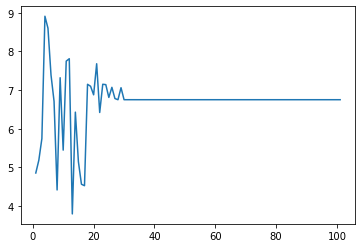

In [ ]:
solution_count = df[df["solution_found"]].shape[0]
print(f"Graph: |V|={graph.num_vertices}, |E|={graph.num_edges}")
print(f"Solution found in {solution_count/runs * 100}% runs")
print(f"Conflicts: mean={df['conflicts'].mean()}, std={df['conflicts'].std()}, mean ratio to vertices={df['conflict_ratio'].mean()}")
print(f"Colors: mean={df['num_colors'].mean()}, std={df['num_colors'].std()}")

# Plot fitness
fitness_developments = np.array(fitness_developments)

# print(fitness_developments)
_ = plt.plot(range(1, num_generations+1+1), fitness_developments.T.mean(axis=-1))

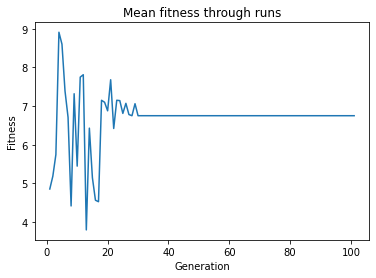

In [ ]:
#save data
import os
import json
import csv


experiment_dir = f"./experiments_edge_manual/{experiment_name}"
if not os.path.exists(experiment_dir):
    os.mkdir(experiment_dir)

params_fout_name = f"{experiment_name}_parameters.json"
results_fout_name = f"{experiment_name}_results.txt"
df_fout_name = f"{experiment_name}_data.csv"
fit_fout_name = f"{experiment_name}_fitness"
fit_plot_fout_name = f"{experiment_name}_mean_fit.png"

with open(os.path.join(experiment_dir, params_fout_name), 'w') as fout:
    serializable_args = {k : str(v) for k, v in ga_args.items()}
    serializable_args['runs'] = runs
    fout.write(json.dumps(serializable_args))
with open(os.path.join(experiment_dir, results_fout_name), 'w') as fout:
    solution_count = df[df["solution_found"]].shape[0]
    fout.write(f"Graph: |V|={graph.num_vertices}, |E|={graph.num_edges}\n")
    fout.write(f"Solution found in {solution_count/runs * 100}% runs\n")
    fout.write(f"Conflicts: mean={df['conflicts'].mean()}, std={df['conflicts'].std()}, mean ratio to vertices={df['conflict_ratio'].mean()}\n")
    fout.write(f"Colors: mean={df['num_colors'].mean()}, std={df['num_colors'].std()}\n")
    fout.write(f"{df.describe()}")
with open(os.path.join(experiment_dir, df_fout_name), 'w') as fout:
    df.to_csv(fout)
with open(os.path.join(experiment_dir, fit_fout_name), 'w') as fout:
    wr = csv.writer(fout)
    wr.writerows(fitness_developments)

# Plots
fig, ax = plt.subplots()

fitness_developments = np.array(fitness_developments)
ax.set(title='Mean fitness through runs', xlabel='Generation', ylabel='Fitness')
_ = ax.plot(range(1, num_generations+1+1), fitness_developments.T.mean(axis=-1))

fig.savefig(os.path.join(experiment_dir, fit_plot_fout_name))